<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес-(Random-Forest)" data-toc-modified-id="Случайный-лес-(Random-Forest)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Случайный лес (Random Forest)</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_score
)


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


random_state = 12345

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])


data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [3]:
print(data.head())
print()
print(data.index.min(), data.index.max())
print()
print(data.shape)

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

2018-03-01 00:00:00 2018-08-31 23:00:00

(4416, 1)


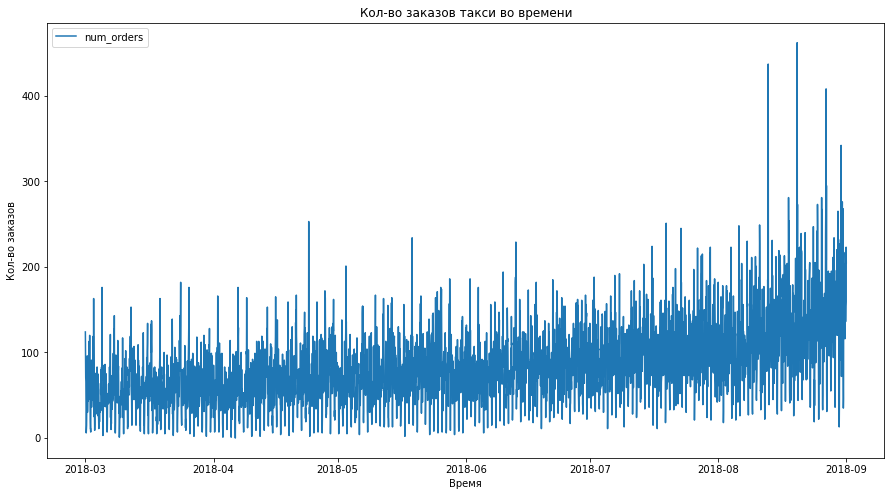

In [4]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=data)
plt.title('Кол-во заказов такси во времени')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов');

Имеем временной ряд, с марта 2008 по конец сентября 2008 года.

## Анализ

Разложим временной ряд на тренд и сезоную составляющие.

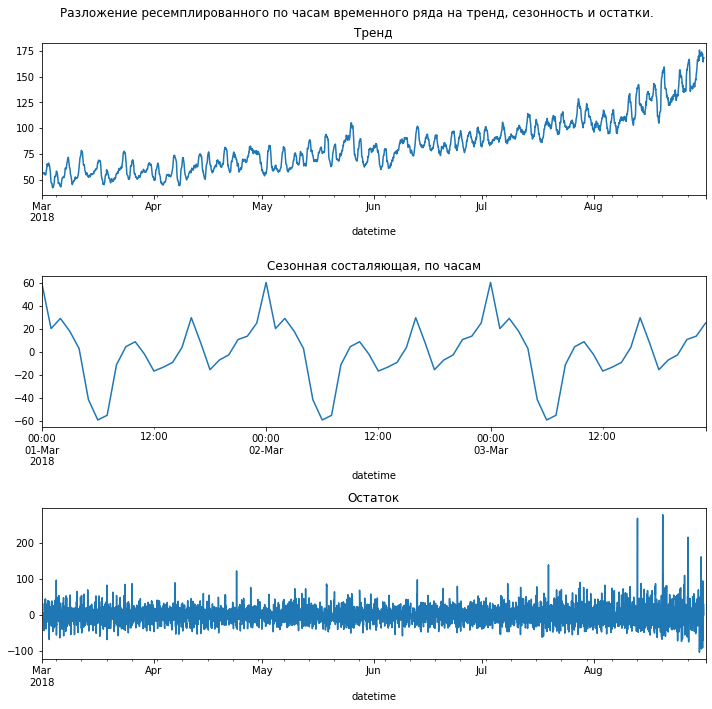

In [5]:
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(10, 10))
plt.suptitle('Разложение ресемплированного по часам временного ряда на тренд, сезонность и остатки.')
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая, по часам')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

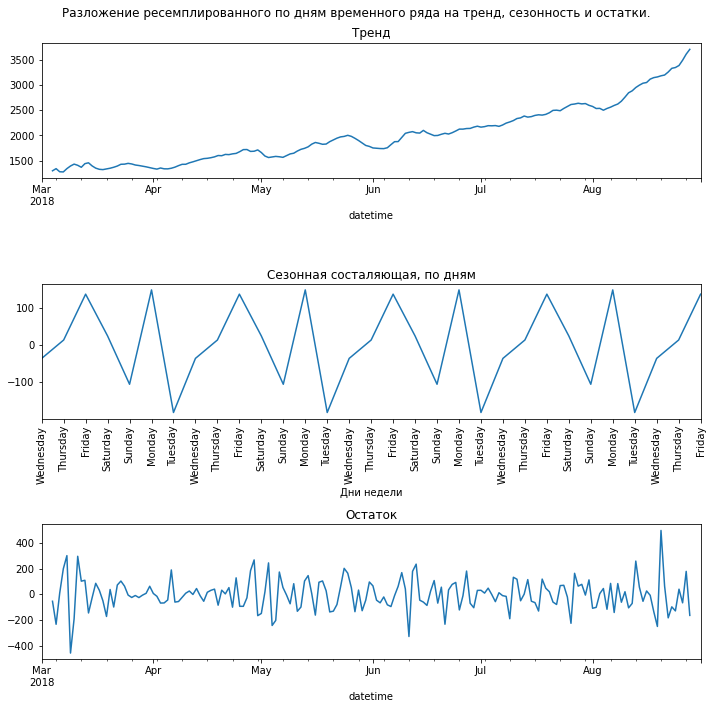

In [6]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())
 
plt.figure(figsize=(10, 10))
plt.suptitle('Разложение ресемплированного по дням временного ряда на тренд, сезонность и остатки.')
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
dec_day = decomposed_day.seasonal['2018-08-01':'2018-08-31']
dec_day.plot(ax=plt.gca())

plt.xticks(ticks= dec_day.index,
           labels = dec_day.index.day_name(),
           rotation=90)
plt.xlabel("Дни недели")
plt.title('Сезонная состаляющая, по дням')

plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

* График часовой сезонности стационарный, на нём чётко видно, что количество заказов зависит от времени суток. Есть несколько пиков: ~10 часов, 16 часов, полночь и ~2 часа ночи. Также есть сильный провал в ~6 утра.


* График дневной сезонности также стационарный, на нём чётко видно, что количество заказов зависит от дня недели. Есть несколько пиков: в пятницу и в понедельник. Самый большой провал во вторник.


* Тренд восходящий, с небольшим ускорением в июне, и с более явным ускорением в августе.


* Остатки к концу августа имеют бОльшую дисперсию, из-за этого могут быть проблемы с предскзаниями.

In [7]:
#Функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Возьмём скользящее среднее равное 24 часам, и максимальный лаг равный 24 часам.

In [8]:
make_features(data, 24, 24)

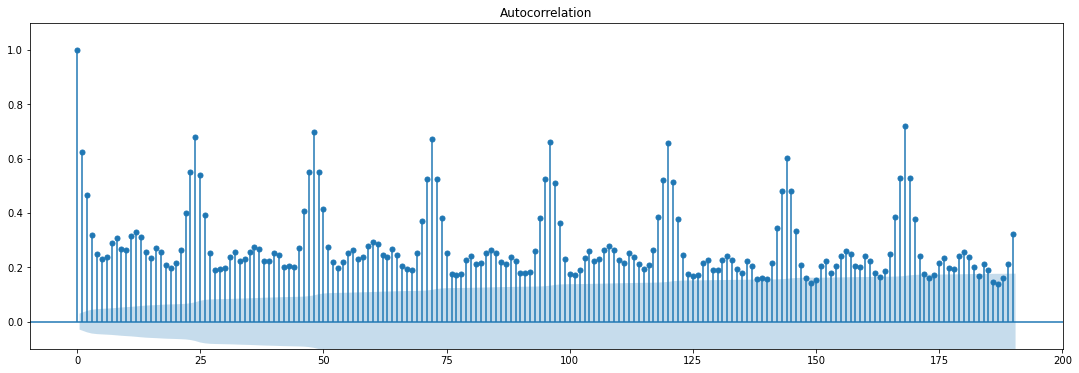

In [9]:

# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



Добавим также сдвинутое на неделю значение.

In [10]:
data['lag_168'] = data['num_orders'].shift(7*24)

In [11]:
print(data.head())
print(data.tail())

                     num_orders  day  hour  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-01 00:00:00         124    1     0          3    NaN    NaN    NaN   
2018-03-01 01:00:00          85    1     1          3  124.0    NaN    NaN   
2018-03-01 02:00:00          71    1     2          3   85.0  124.0    NaN   
2018-03-01 03:00:00          66    1     3          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43    1     4          3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_17  lag_18  lag_19  lag_20  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...   

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']
print(features_train.shape,features_test.shape,target_train.shape,target_test.shape)

(3806, 29) (442, 29) (3806,) (442,)


In [13]:
features_train.head()

,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,8,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,60.041667,124.0
2018-03-08 01:00:00,8,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,61.833333,85.0
2018-03-08 02:00:00,8,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,60.041667,71.0
2018-03-08 03:00:00,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,61.750000,66.0
2018-03-08 04:00:00,8,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,61.833333,43.0


Мы подготовили данные, и теперь можем переходить к обучению моделей.

## Обучение

Проведём масштабирование признаков.

In [14]:
features = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV.

### Случайный лес (Random Forest)

Найдём оптимальные гиперпараметры для модели Random Forest.

In [15]:
%%time

model_rf = RandomForestRegressor(random_state=random_state)
parametrs = {'n_estimators': range(10,151,10),
              'max_depth': range(2, 11)}

search_rf = GridSearchCV(model_rf, parametrs, cv=TimeSeriesSplit(n_splits=3), scoring='neg_root_mean_squared_error', n_jobs=-1)
search_rf.fit(features_train, target_train)

print(f'RMSE лучшей модели: {-search_rf.best_score_}, с параметрами: {search_rf.best_params_}')

RMSE лучшей модели: 23.925108543498357, с параметрами: {'max_depth': 10, 'n_estimators': 140}
CPU times: total: 6.33 s
Wall time: 1min 44s


### LightGBM

Найдём оптимальные гиперпараметры для модели LightGBM.

In [16]:
%%time

model_lgb = LGBMRegressor(random_state=random_state)
parametrs = {'n_estimators': [10, 100, 1000],'max_depth': range(2, 11)}

search_lgb = GridSearchCV(model_lgb, parametrs, cv=TimeSeriesSplit(n_splits=3),\
                          scoring='neg_root_mean_squared_error', n_jobs=-1)
search_lgb.fit(features_train, target_train)

print(f'RMSE лучшей модели: {-search_lgb.best_score_}, с параметрами: {search_lgb.best_params_}')

RMSE лучшей модели: 23.643990987827483, с параметрами: {'max_depth': 2, 'n_estimators': 100}
CPU times: total: 406 ms
Wall time: 9.51 s


### CatBoost

Найдём оптимальные гиперпараметры для модели CatBoost

In [23]:
%%time

model_cbr = CatBoostRegressor(random_state=random_state)
parametrs = {'n_estimators': [10, 100, 1000],'max_depth': range(2, 11)}

search_cbr = GridSearchCV(model_cbr, parametrs, cv=TimeSeriesSplit(n_splits=3),\
                          scoring='neg_root_mean_squared_error', n_jobs=-1)
search_cbr.fit(features_train, target_train)

print(f'RMSE лучшей модели: {-search_cbr.best_score_}, с параметрами: {search_cbr.best_params_}')

Learning rate set to 0.05057
0:	learn: 37.6476748	total: 47.7ms	remaining: 47.6s
1:	learn: 36.6752222	total: 49.3ms	remaining: 24.6s
2:	learn: 35.7997212	total: 51ms	remaining: 16.9s
3:	learn: 35.0020457	total: 52.6ms	remaining: 13.1s
4:	learn: 34.1904704	total: 53.9ms	remaining: 10.7s
5:	learn: 33.4140836	total: 55.1ms	remaining: 9.13s
6:	learn: 32.6939709	total: 56.5ms	remaining: 8.01s
7:	learn: 32.0238527	total: 57.9ms	remaining: 7.18s
8:	learn: 31.4242480	total: 59.2ms	remaining: 6.52s
9:	learn: 30.8441864	total: 60.7ms	remaining: 6.01s
10:	learn: 30.3430642	total: 62.2ms	remaining: 5.59s
11:	learn: 29.8554071	total: 63.5ms	remaining: 5.22s
12:	learn: 29.3846685	total: 64.7ms	remaining: 4.91s
13:	learn: 28.8990292	total: 66ms	remaining: 4.65s
14:	learn: 28.4727905	total: 67.4ms	remaining: 4.43s
15:	learn: 28.0869114	total: 68.8ms	remaining: 4.23s
16:	learn: 27.7160915	total: 70.1ms	remaining: 4.05s
17:	learn: 27.3831168	total: 71.4ms	remaining: 3.89s
18:	learn: 27.0835016	total: 83

### Линейная регрессия

In [24]:
model_lr = LinearRegression()
#model_lr.fit(features_train,target_train)
#predictions_lr = model_lr.predict(features_train)

scores = cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error',\
                         cv=TimeSeriesSplit(n_splits=3)).mean()

print('RMSE Линейной регрессии:', -1*scores)

RMSE Линейной регрессии: 23.62519726171789


Наилучшие показатели метрики показала модель CatBoost, но тестировать мы будем линейную регрессию, поскольку кое что знаем)

Перейдём к тестированию данной модели.

## Тестирование

In [25]:
best_model = LinearRegression()
best_model.fit(features_train, target_train)

predictions_train = best_model.predict(features_train)
rmse_train = mean_squared_error(target_train, predictions_train)**0.5

predictions_test = best_model.predict(features_test)
rmse_test = mean_squared_error(target_test, predictions_test)**0.5

print('RMSE на обучающей выборке:', rmse_train)
print('RMSE на тестовой выборке:', rmse_test)

RMSE на обучающей выборке: 22.164762092664017
RMSE на тестовой выборке: 35.00318104084116


Выведем коэфициенты получившейся модели.

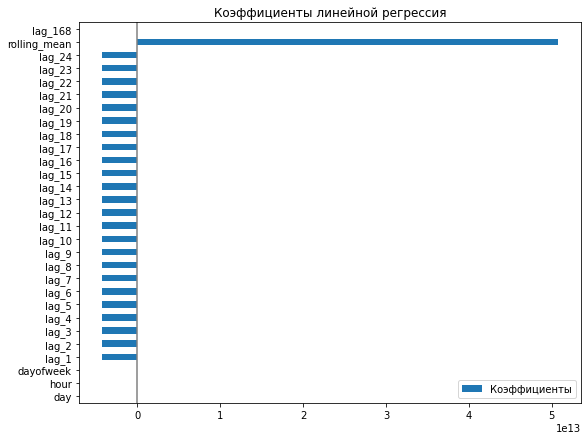

In [26]:
coefs = pd.DataFrame(
   best_model.coef_,
   columns=['Коэффициенты'], index=features
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Коэффициенты линейной регрессия')
plt.axvline(x=0, color='.5');

Визуализируем фактические данные и наши предсказания.

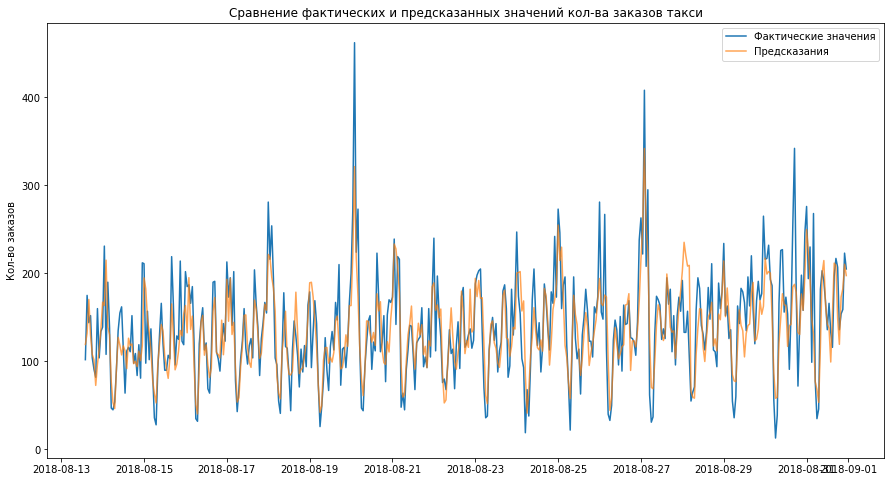

In [27]:
plt.figure(figsize=(15, 8)) 
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, predictions_test, alpha=0.7)
plt.title('Сравнение фактических и предсказанных значений кол-ва заказов такси')
plt.ylabel('Кол-во заказов')
plt.legend(('Фактические значения', 'Предсказания'));

Визуально, получившаяся модель достаточно не плохо описывает динамику целевого признака. Но при этом не достаточно хорошо описывает пиковые значения.

Проверим нашу модель на адекватность. В случае с временными рядами модель будет предсказывать следующее значение предыдущим:

In [28]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse = mean_squared_error(target_test, pred_previous)**0.5
print('RMSE:', rmse)

RMSE: 58.856486242815066


Видим, что наша модель имеет значительно лучшую метрику. Значит в нашей работе есть смысл!)

## Итоговый вывод

Мы обучили несколько моделей, для каждой модели подобрали оптимальные параметры, нашли лучшую модель и выполнили предсказание на тестовой выборке. Лучшие показатели оказались у линейной регресии.

* RMSE на обучающей выборке: 22.164762092664017
* RMSE на тестовой выборке: 35.00318104084116

Требование о значении метрики RMSE (не более 48) выполнено.